In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random
#import helper functions

torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(128)
torch.cuda.is_available()

True

In [29]:
class AddNoise(object):
    def __init__(self, alpha=70.0, sigma=0.1):
        super().__init__()
        self.alpha = alpha
        self.sigma = sigma
        
    def __call__(self, tensor):
        t = transforms.Compose([transforms.ElasticTransform(self.alpha,self.sigma)]) 
        return torch.clamp(tensor.add(t(tensor)), 0,1)
    


#Alpha is closeness and sigma is amount
# custom_transform = transforms.Compose([ToTensor(), transforms.RandomAffine(degrees=30, translate=(0.4,0.4), scale=(0.35, 1.25), shear=(-30,30, -30,30)),AddNoise(70.0, 0.1),]) 
custom_transform = transforms.Compose([ToTensor(), transforms.RandomAffine(degrees=30, translate=(0.4,0.4), scale=(0.35, 1.25), shear=(-30,30, -30,30)),AddNoise(180.0, 1.0),]) 


In [4]:
#Visualising data
# Download the dataset first
train_data = datasets.MNIST("~/data", train=True, download=True, )
test_data = datasets.MNIST("~/data", train=False, download=True, )

# custom_transform = transforms.Compose([ToTensor(),transforms.RandomResizedCrop(size=28, scale=(0.5, 1.0), ratio=(1.0, 1.0))]) # Model 2
# custom_transform = transforms.Compose([ToTensor(),transforms.RandomAffine(degrees=10, translate=(0.4,0.4), scale=(0.25, 1.25), shear=(-20,20))]) #Model 3
# custom_transform = transforms.Compose([ToTensor(),transforms.RandomAffine(degrees=30, translate=(0.4,0.4), scale=(0.25, 1.25), shear=(-30,30, -30,30))]) #Model 3
# custom_transform = transforms.Compose([ToTensor()]) #Model 3.1

train_loader = DataLoader(
        datasets.MNIST("./data", train=True, download=True, transform=custom_transform,),
        batch_size=128,
        shuffle=True,) #num_workers=4, pin_memory=True)
test_loader = DataLoader(
        datasets.MNIST("./data", train=False, download=True, transform=custom_transform,),
        batch_size=128,
        shuffle=False, )#num_workers=4, pin_memory=True)


# images, labels = next(iter(test_loader))
# plt.imshow(images[0].squeeze())

In [30]:
visual_loader = DataLoader(
        datasets.MNIST("./data", train=False, download=True, transform=ToTensor()),
        batch_size=128,
        shuffle=False,)#num_workers=4, pin_memory=True)
images, labels = next(iter(visual_loader))

Text(0.5, 1.0, 'customized 4')

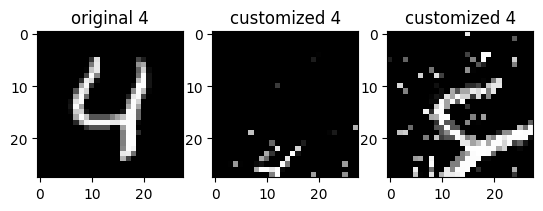

In [ ]:
#Visualazition


custom_transform = transforms.Compose([transforms.RandomAffine(degrees=30, translate=(0.4,0.4), scale=(0.35, 1.25), shear=(-30,30, -30,30)),AddNoise(70.0, 0.1),]) #Model 3

f, axarr = plt.subplots(1,3)
axarr[0].imshow(images[4].squeeze(), cmap="gray")
axarr[0].set_title("original "+str(labels[4].item()))
axarr[1].imshow(custom_transform(images[4]).squeeze(), cmap="gray")
axarr[1].set_title("customized "+str(labels[4].item()))
axarr[2].imshow(custom_transform(images[4]).squeeze(), cmap="gray")
axarr[2].set_title("customized "+str(labels[4].item()))

# plt.imshow(images[4].squeeze(), cmap="gray")
# plt.title(labels[4].item())

In [142]:
#! Unable to 
#Familier model, best 98.69% epoch 6
#nn.CrossEntropyLoss(),
#optim.Adam(params=model_0.parameters(), lr=0.001, weight_decay=0.001),

class digit_classifier(nn.Module):
  def __init__(self, hidden=10):
    super(digit_classifier, self).__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        #Don't work with onnx?
        nn.MaxPool2d(kernel_size=2, stride=2)#14/2
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        #Don't work with onnx?
         nn.MaxPool2d(kernel_size=2, stride=2)#14/2

       
    )
    self.output = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, len(train_data.classes))
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x =  self.output(x)
    #! Don't use softmax, stabilty reason? 
    return x
model_0 = digit_classifier(20).to(device) #Only one input channel

In [43]:
class digit_classifier_1(nn.Module):
  def __init__(self, hidden=10):
    super(digit_classifier_1, self).__init__()

    self.block_1 = nn.Sequential(
        nn.BatchNorm2d(1),
        nn.Conv2d(in_channels=1, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        #Don't work with onnx?
        nn.MaxPool2d(kernel_size=2, stride=2),#14/2
    )
    self.block_2 = nn.Sequential(
        nn.BatchNorm2d(hidden),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        #Don't work with onnx?
        nn.MaxPool2d(kernel_size=2, stride=2), #14/2

    )
    self.output = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, hidden*7*7),
        nn.Linear(hidden*7*7, len(train_data.classes)),
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x =  self.output(x)
    return x
model_1 = digit_classifier_1(25).to(device)
net = nn.DataParallel(model_1)

In [33]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optim: torch.optim,
               device: torch.device,
               print_output:bool=True):
    model.train()
    train_loss, train_acc = 0, 0
    for (X, y) in dataloader :#tqdm inside enumrater

        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        train_loss += loss # ?.item()

        optim.zero_grad()

        loss.backward()

        optim.step()

    train_acc /= len(dataloader)
    train_loss /= len(dataloader)

    if print_output: print(f"train: {train_loss}, {train_acc}%")  
    return [train_loss.item(), train_acc]

def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device,
               print_output:bool=True):
    ##Testing
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            # if test_loss == 0:
            #     plt.imshow(X[0].squeeze())
            #     plt.title(y[0].item())
            #     plt.show()
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch
            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
    
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    if print_output: print(f"test: {test_loss}, {test_acc}%")
    return test_acc



In [46]:
#86%
epochs = 1

model_1.to(device)
#? Scedchuler
if __name__ == '__main__':
  for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n--------")
    train_step(model_1, train_loader,
            nn.CrossEntropyLoss(),
            optim.SGD(params=model_1.parameters(), lr=0.2),
            device)

    test_step(model_1, test_loader,
            nn.CrossEntropyLoss(),
            device)
        
        

Epoch 1
--------
train: 0.47194164991378784, 85.08073471926085%
test: 0.42280131578445435, 86.44185126582279%


In [41]:
#Making some predictions
#? 15 nodes
#88% 25 nodes
#88% 35 nodes
model_1.to(device="cpu")
x = torch.zeros(1,1,28,28)
model_1.eval()

torch.onnx.export(model_1,             
                  x,                   
                  "model_4.onnx",   
                  opset_version=9,     
                  verbose=True,       
                  )


x.shape

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



torch.Size([1, 1, 28, 28])